<a href="https://colab.research.google.com/github/1587causalai/AboutCausalAI/blob/master/disco_mnist_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DiscoSCM mnist

## data

In [2]:
#构建一个类线性模型类，继承自nn.Module,nn.m中封装了许多方法
#本模型所用的包含库
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset    #这是一个抽象类，无法实例化
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import os
#构建一个compose类的实例，包含转tensor（张量），后面那个是标准化，两个参数分别是均值和标准差
train_transform = transforms.Compose([
                                transforms.RandomAffine(degrees = 0,translate=(0.1, 0.1)),#对照片进行随机平移
                                transforms.RandomRotation((-10,10)),        #随机旋转
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))])
test_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.1307,),(0.3081,))])
#这2个值也是调参重灾区……
train_batch_size = 256
learning_rate = 0.06
test_batch_size = 100
random_seed = 2         # 随机种子，设置后可以得到稳定的随机数
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) #为gpu提供随机数
train_dataset = datasets.MNIST(root='./dataset/mnist/', train=True, download=True, transform=train_transform)
test_dataset = datasets.MNIST(root='./dataset/mnist/', train=False, download=True, transform=test_transform)
train_loader = DataLoader(dataset=train_dataset,batch_size=train_batch_size,shuffle=True,pin_memory=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=test_batch_size,shuffle=False,pin_memory=True)

## model

In [3]:
class ResidualBlock(nn.Module):
    # Residual Block需要保证输出和输入通道数x一样
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.channels = channels
        # 3*3卷积核，保证图像大小不变将padding设为1
        # 第一个卷积
        self.conv1 = nn.Conv2d(channels, channels,
                               kernel_size=3, padding=1)
        # 第二个卷积
        self.conv2 = nn.Conv2d(channels, channels,
                               kernel_size=3, padding=1)
        #第三个卷积，1*1
        self.conv3 = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        # 激活
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        # 先求和 后激活
        z = self.conv3(x)
        return F.relu(z + y)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #卷积层
        self.conv1 = nn.Conv2d(1  ,32, kernel_size=5,padding=2)
        self.conv2 = nn.Conv2d(32 ,64, kernel_size=5,padding=2)
        self.conv3 = nn.Conv2d(64 ,128,kernel_size=5,padding=2)
        self.conv4 = nn.Conv2d(128,192,kernel_size=5,padding=2)

        #残差神经网络层，其中已经包含了relu
        self.rblock1 = ResidualBlock(32)
        self.rblock2 = ResidualBlock(64)
        self.rblock3 = ResidualBlock(128)
        self.rblock4 = ResidualBlock(192)

        #BN层，归一化，使数据在进行Relu之前不会因为数据过大而导致网络性能的不稳定
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(192)

        #最大池化，一般最大池化效果都比平均池化好些
        self.mp = nn.MaxPool2d(2)

        #fully connectected全连接层
        self.fc1 = nn.Linear(192*7*7, 256)  # 线性
        self.fc6 = nn.Linear(256, 10)  # 线性

    def forward(self, x):
        in_size = x.size(0)

        x = self.conv1(x)   #channels:1-32  w*h:28*28
        x = self.bn1(x)
        x = F.relu(x)
        x = self.rblock1(x)

        x = self.conv2(x)   #channels:32-64 w*h:28*28
        x = F.relu(x)
        x = self.bn2(x)
        x = self.rblock2(x)

        x = self.mp(x)      #最大池化,channels:64-64    w*h:28*28->14*14


        x = self.conv3(x)   #channels:64-128    w*h:14*14
        x = self.bn3(x)
        x = F.relu(x)
        x = self.rblock3(x)

        x = self.conv4(x)   #channels:128-192   w*h:14*14
        x = self.bn4(x)
        x = F.relu(x)
        x = self.rblock4(x)

        x = self.mp(x)      #最大池化,channels:192-192  w*h:14*14->7*7

        x = x.view(in_size, -1)     #展开成向量
        x = F.relu(self.fc1(x))  # 使用relu函数来激活

        return self.fc6(x)

## train

In [7]:
#把训练封装成一个函数
def train(epoch):
    running_loss =0.0
    for batch_idx,data in enumerate(train_loader,0):

        if batch_idx%10 == 0:
            continue

        inputs,target = data
        inputs,target = inputs.to(device),target.to(device)
        optimizer.zero_grad()

        #forward,backward,update
        outputs = model(inputs)
        loss = criterion(outputs,target)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        if batch_idx%300==299:
            train_loss_val.append((running_loss/300))
            #print('[%d,%5d] loss:%3f'%(epoch+1,batch_idx+1,running_loss/300))
            print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 300))
            running_loss = 0.0


In [8]:
#把测试封装成函数
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            #torch.max()返回的是两个值，第一个是用_接受(蚌埠住了),第二个是pre
            _, predicted = torch.max(outputs.data,dim=1)       #从第一维度开始搜索
            total += labels.size(0)
            correct += (predicted==labels).sum().item()
    print('Accuracy on test set: %f %% [%d/%d]' % (100 * correct / total, correct, total))

    return correct/total

Accuracy on test set: 98.820000 % [9882/10000]
1 0.9882
Accuracy on test set: 99.330000 % [9933/10000]
2 0.9933
Accuracy on test set: 99.420000 % [9942/10000]
3 0.9942
Accuracy on test set: 99.280000 % [9928/10000]
4 0.9928
Accuracy on test set: 99.560000 % [9956/10000]
5 0.9956
Accuracy on test set: 99.190000 % [9919/10000]
6 0.9919
Accuracy on test set: 99.640000 % [9964/10000]
7 0.9964
Accuracy on test set: 99.480000 % [9948/10000]
8 0.9948
Accuracy on test set: 99.590000 % [9959/10000]
9 0.9959
Accuracy on test set: 99.440000 % [9944/10000]
10 0.9944
Epoch 00010: reducing learning rate of group 0 to 3.0000e-02.


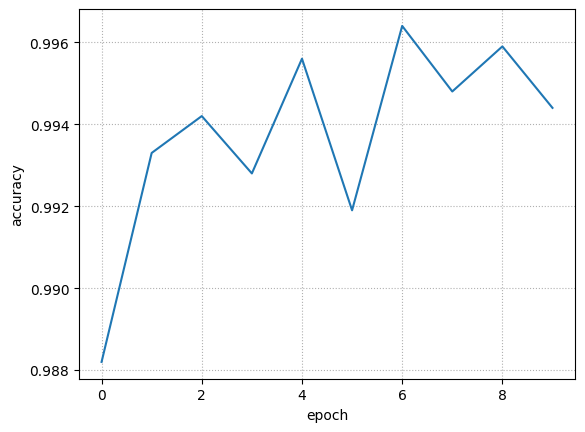

In [9]:
train_epoch = []
model_accuracy = []
temp_acc = 0.0
train_loss_val = []
for epoch in range(10):
    train(epoch)
    acc = test()

    print(epoch + 1,acc)
    train_epoch.append(epoch)
    model_accuracy.append(acc)
    scheduler.step(acc)

plt.figure(1)
plt.plot(train_epoch, model_accuracy)  # 传入列表，plt类用来画图
plt.grid(linestyle=':')
plt.ylabel('accuracy')  # 定义y坐标轴的名字
plt.xlabel('epoch')  # 定义x坐标
plt.show()  # 显示

## 网络结构修改

In [26]:
#调用GPU
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
torch.backends.cudnn.benchmark = True       #启用cudnn底层算法
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
#构建一个类线性模型类，继承自nn.Module,nn.m中封装了许多方法
#本模型所用的包含库
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset    #这是一个抽象类，无法实例化
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import os
#构建一个compose类的实例，包含转tensor（张量），后面那个是标准化，两个参数分别是均值和标准差
train_transform = transforms.Compose([
                                transforms.RandomAffine(degrees = 0,translate=(0.1, 0.1)),#对照片进行随机平移
                                transforms.RandomRotation((-10,10)),        #随机旋转
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))])
test_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.1307,),(0.3081,))])
#这2个值也是调参重灾区……
train_batch_size = 256
learning_rate = 0.06
test_batch_size = 100
random_seed = 2         # 随机种子，设置后可以得到稳定的随机数
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) #为gpu提供随机数
train_dataset = datasets.MNIST(root='./dataset/mnist/', train=True, download=False, transform=train_transform)
test_dataset = datasets.MNIST(root='./dataset/mnist/', train=False, download=False, transform=test_transform)
train_loader = DataLoader(dataset=train_dataset,batch_size=train_batch_size,shuffle=True,pin_memory=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=test_batch_size,shuffle=False,pin_memory=True)

class ResidualBlock(nn.Module):
    # Residual Block需要保证输出和输入通道数x一样
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.channels = channels
        # 3*3卷积核，保证图像大小不变将padding设为1
        # 第一个卷积
        self.conv1 = nn.Conv2d(channels, channels,
                               kernel_size=3, padding=1)
        # 第二个卷积
        self.conv2 = nn.Conv2d(channels, channels,
                               kernel_size=3, padding=1)
        #第三个卷积，1*1
        self.conv3 = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        # 激活
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        # 先求和 后激活
        z = self.conv3(x)
        return F.relu(z + y)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #卷积层
        self.conv1 = nn.Conv2d(1  ,32, kernel_size=5,padding=2)
        self.conv2 = nn.Conv2d(32 ,64, kernel_size=5,padding=2)
        self.conv3 = nn.Conv2d(64 ,128,kernel_size=5,padding=2)
        self.conv4 = nn.Conv2d(128,192,kernel_size=5,padding=2)

        #残差神经网络层，其中已经包含了relu
        self.rblock1 = ResidualBlock(32)
        self.rblock2 = ResidualBlock(64)
        self.rblock3 = ResidualBlock(128)
        self.rblock4 = ResidualBlock(192)

        #BN层，归一化，使数据在进行Relu之前不会因为数据过大而导致网络性能的不稳定
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(192)

        #最大池化，一般最大池化效果都比平均池化好些
        self.mp = nn.MaxPool2d(2)

        #fully connectected全连接层
        self.fc1 = nn.Linear(192*7*7, 256)  # 线性
        self.fc6 = nn.Linear(256, 10)  # 线性

    def forward(self, x, eps=1e-4):
        in_size = x.size(0)

        x = self.conv1(x)   #channels:1-32  w*h:28*28
        x = self.bn1(x)
        x = F.relu(x)
        x = self.rblock1(x)

        x = self.conv2(x)   #channels:32-64 w*h:28*28
        x = F.relu(x)
        x = self.bn2(x)
        x = self.rblock2(x)
        x = self.mp(x)      #最大池化,channels:64-64    w*h:28*28->14*14

        x = self.conv3(x)   #channels:64-128    w*h:14*14
        x = self.bn3(x)
        x = F.relu(x)
        x = self.rblock3(x)
        x = self.conv4(x)   #channels:128-192   w*h:14*14
        x = self.bn4(x)
        x = F.relu(x)
        x = self.rblock4(x)
        x = self.mp(x)      #最大池化,channels:192-192  w*h:14*14->7*7

        z = x.view(in_size, -1)     #展开成向量
        out = self.fc6(F.relu(self.fc1(z)))

        u = z.clone().detach()
        y1 = self.fc6(F.relu(self.fc1(u)))
        y2 = self.fc6(F.relu(self.fc1(u+eps)))
        z_prime = (y2-y1)/eps

        return out, z_prime

## 测试代码

In [45]:
#把训练封装成一个函数
def train(epoch, eps=1e-4, coef=0, thres=-5):
    running_loss =0.0
    for batch_idx,data in enumerate(train_loader,0):

        if np.random.randn() < thres:
            inputs,target = data
            break

        inputs,target = data
        inputs,target = inputs.to(device),target.to(device)
        optimizer.zero_grad()

        #forward,backward,update
        outputs, z_prime = model(inputs, eps=eps)
        loss = criterion(outputs,target) + torch.sum(z_prime**2) * coef
        loss.backward()
        optimizer.step()


        running_loss+=loss.item()
        if batch_idx%300==299:
            train_loss_val.append((running_loss/300))
            #print('[%d,%5d] loss:%3f'%(epoch+1,batch_idx+1,running_loss/300))
            print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 300))
            running_loss = 0.0


#把测试封装成函数
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs, z_prime = model(images)
            #torch.max()返回的是两个值，第一个是用_接受(蚌埠住了),第二个是pre
            _, predicted = torch.max(outputs.data,dim=1)       #从第一维度开始搜索
            total += labels.size(0)
            correct += (predicted==labels).sum().item()
            if np.random.randn(1) > 2:
                tmp = torch.mean(z_prime**2)
                print(f'repre grad loss {tmp}')
    print('Accuracy on test set: %f %% [%d/%d]' % (100 * correct / total, correct, total))

    return correct/total

repre grad loss 9.72244644165039
repre grad loss 9.809561729431152
Accuracy on test set: 99.050000 % [9905/10000]
epoch=1, acc=0.9905
repre grad loss 13.301817893981934
repre grad loss 13.571625709533691
Accuracy on test set: 99.150000 % [9915/10000]
epoch=2, acc=0.9915
repre grad loss 9.797003746032715
repre grad loss 9.796246528625488
Accuracy on test set: 99.230000 % [9923/10000]
epoch=3, acc=0.9923
repre grad loss 10.517037391662598
Accuracy on test set: 99.130000 % [9913/10000]
epoch=4, acc=0.9913
Accuracy on test set: 99.530000 % [9953/10000]
epoch=5, acc=0.9953
repre grad loss 13.782278060913086
Accuracy on test set: 99.230000 % [9923/10000]
epoch=6, acc=0.9923
repre grad loss 10.736647605895996
Accuracy on test set: 99.520000 % [9952/10000]
epoch=7, acc=0.9952
repre grad loss 10.858465194702148
repre grad loss 10.821358680725098
Accuracy on test set: 99.510000 % [9951/10000]
epoch=8, acc=0.9951
Epoch 00008: reducing learning rate of group 0 to 3.0000e-02.
repre grad loss 12.815

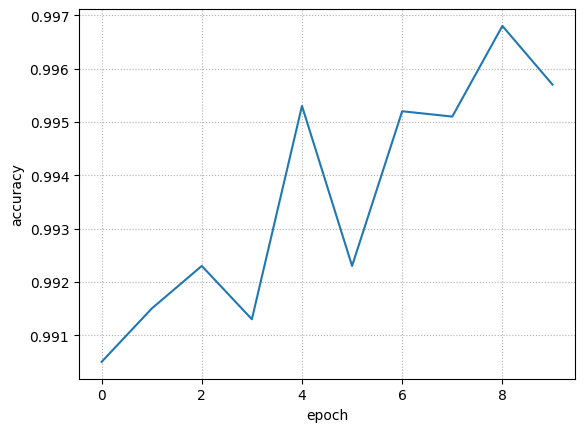

In [46]:
#print(device)
torch.cuda.empty_cache()        #释放显存

model = Net()
model.to(device)

# #构建损失函数
criterion = torch.nn.CrossEntropyLoss()      #交叉熵
#
# #构建优化器,参数1：模型权重，参数二，learning rate
optimizer = optim.SGD(model.parameters(),lr=learning_rate,momentum=0.5)    #带动量0.5

#optimizer = optim.RMSprop(model.parameters(),lr=learning_rate,alpha=0.99,momentum = 0.5)
# optimizer = torch.optim.Adam(model.parameters(),
#                              lr=0.05,
#                              betas=(0.9, 0.999),
#                              eps=1e-08,
#                              weight_decay=0,
#                              amsgrad=False)
#设置学习率梯度下降，如果连续2个epoch测试准确率没有上升，则降低学习率，系数0.5
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True, threshold=0.00005, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

train_epoch = []
model_accuracy = []
temp_acc = 0.0
train_loss_val = []
for epoch in range(10):
    train(epoch, eps=1e-1*100, coef=1e-4 * 0)
    acc = test()

    print(f'epoch={epoch + 1}, acc={acc}')
    train_epoch.append(epoch)
    model_accuracy.append(acc)
    scheduler.step(acc)

plt.figure(1)
plt.plot(train_epoch, model_accuracy)  # 传入列表，plt类用来画图
plt.grid(linestyle=':')
plt.ylabel('accuracy')  # 定义y坐标轴的名字
plt.xlabel('epoch')  # 定义x坐标
plt.show()  # 显示

In [1]:
for epoch in range(10):
    train(epoch, eps=1e-5, coef=1e-4*0)
    acc = test()

    print(f'epoch={epoch + 1}, acc={acc}')
    train_epoch.append(epoch)
    model_accuracy.append(acc)
    scheduler.step(acc)

NameError: ignored